In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import pylab as plb
import numpy as np
import seaborn as sns; sns.set()

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.model_selection import cross_val_score


from sklearn.preprocessing import power_transform
sns.set(font_scale=1.5)
%matplotlib inline

# Loading data and creating new variables

In [2]:
df = pd.read_excel('Dummy Dataset.xlsx', sheet_name ='Final Data')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_week'] = df['Date'].dt.weekday

df['Clicks'] = df['Clicks']+1
df['CTR'] = df['Clicks']/df['Impressions']

df['CPC'] = df['Spend']/df['Clicks']
df['Product Views'] = df['Product Views']+1
df['CPPV'] = df['Spend']/df['Product Views']
df['Adds to Cart'] = df['Adds to Cart']+1
df['CPPAC'] = df['Spend']/df['Adds to Cart']
df['CPP'] = df['Spend']/df['Purchases']
df['ROAS'] = df['Revenue']/df['Spend']
df['Conversion_Rate1'] = df['Purchases']/df['Impressions']
df['Conversion_Rate2'] = df['Purchases']/df['Clicks']
df['Profit'] = df['Revenue']-df['Spend']

# What to predict? CTR, Revenue, ROAS?
* Multicollinearity? there are so many variables and may not be worth diving down into each since we already know that many metrics depend on each other and that collinearity exist. 
* There are a lot of problems in this data set and that Feature engineering could be a huge part of it. I won't go into all the details because it will take too long to do. 
* However, if in a real life situation we should take our time and conduct a lot of research in feature engineering. We all know garbage in garbage out so it is equivalently important to do feature engineering it is to test out multiple models. 
* Note without remove collinearity there it is likely that we will be overfitting

# Scatter Plots to quickly examine relationship between predictors and the dependent variable Revenue 

* I decided to predict revenue since we already know CTR is made from the predictors Clicks and Impressions

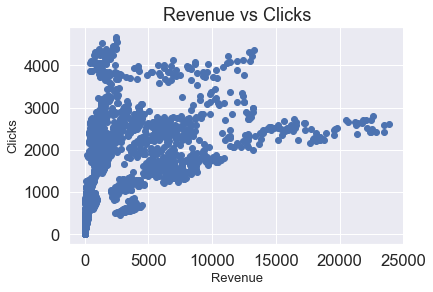

In [3]:
plt.scatter(df['Revenue'], df['Clicks'])
plt.ylabel('Clicks', fontsize=13)
plt.xlabel('Revenue', fontsize=13)
plt.title('Revenue vs Clicks')
plt.show()

In [4]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df['Revenue'], df['Clicks'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.474


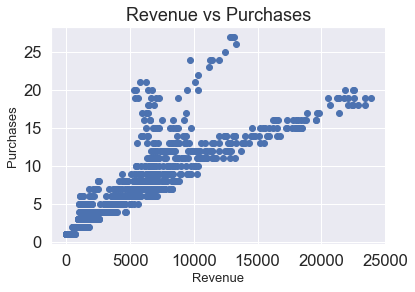

In [5]:
plt.scatter(df['Revenue'], df['Purchases'])
plt.ylabel('Purchases', fontsize=13)
plt.xlabel('Revenue', fontsize=13)
plt.title('Revenue vs Purchases')
plt.show()

In [6]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df['Revenue'], df['Purchases'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.905


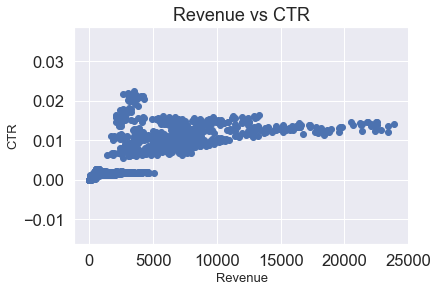

In [7]:
plt.scatter(df['Revenue'], df['CTR'])
plt.ylabel('CTR', fontsize=13)
plt.xlabel('Revenue', fontsize=13)
plt.title('Revenue vs CTR')
plt.show()

In [8]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df['Revenue'], df['CTR'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.755


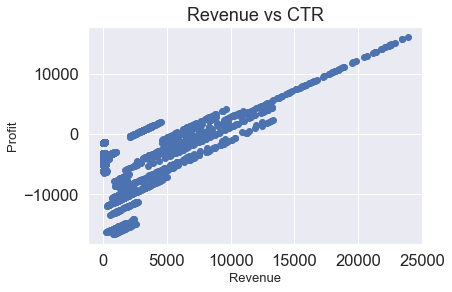

In [9]:
plt.scatter(df['Revenue'], df['Profit'])
plt.ylabel('Profit', fontsize=13)
plt.xlabel('Revenue', fontsize=13)
plt.title('Revenue vs CTR')
plt.show()

In [10]:
from scipy.stats import spearmanr
corr, _ = pearsonr(df['Revenue'], df['Profit'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.659


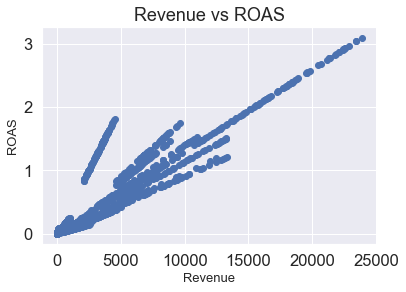

In [12]:
plt.scatter(df['Revenue'], df['ROAS'])
plt.ylabel('ROAS', fontsize=13)
plt.xlabel('Revenue', fontsize=13)
plt.title('Revenue vs ROAS')
plt.show()

In [13]:
from scipy.stats import spearmanr
corr, _ = pearsonr(df['Revenue'], df['ROAS'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.916


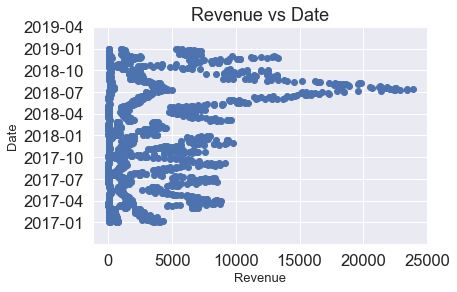

In [15]:
plt.scatter(df['Revenue'], df['Date'])
plt.ylabel('Date', fontsize=13)
plt.xlabel('Revenue', fontsize=13)
plt.title('Revenue vs Date')
plt.show()

# Distributions

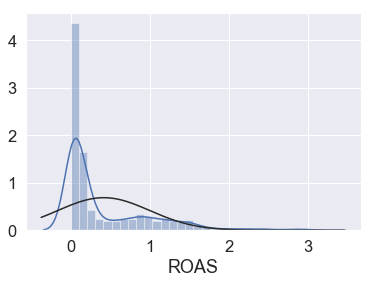

In [26]:
sns.distplot(df['ROAS'], fit = norm)
plt.show()

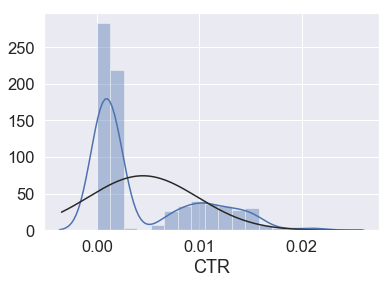

In [16]:
sns.distplot(df['CTR'], fit = norm)
plt.show()

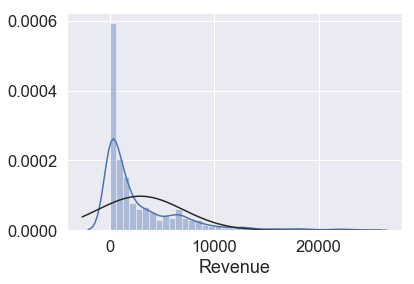

In [17]:
sns.distplot(df['Revenue'], fit = norm)
plt.show()

### It isn't necessary to transform the dependent variable, but usually provides better prediction results. This is really because if we think about a glm model simple linear regression assumes normality. People tend to only realize that residuals should be normally distributed but under glm we know that there exist as soft assumption of normality. 

### Notice that even after a log transformation the values are left skewed! 

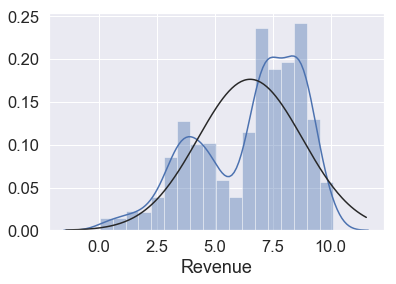

In [18]:
sns.distplot(np.log1p(df['Revenue']), fit= norm)
plt.show()

### The Box-Cox transformation is a family of power transform functions that are used to stabilize variance and make a dataset look more like a normal distribution.
### Now after the Box-Cox its much more normal. Doing this well help with prediction.

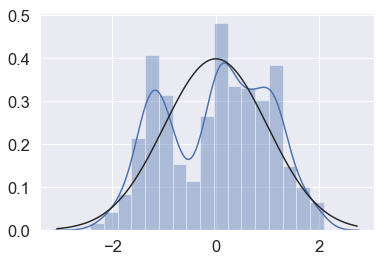

In [19]:
transformed = []
for i in power_transform(df['Revenue'].values.reshape(-1,1), method='box-cox'):
    transformed.append(i[0])
sns.distplot(transformed, fit = norm)

In [20]:
# box cox transform now reassign
df['Revenue'] = np.log1p(df['Revenue'])

# Correlation Heatmap

In [21]:
from operator import itemgetter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score

df_for_pred = df

# Turning dates to ordinal values for prediction!!!!!!!
df_for_pred['Date'] =df_for_pred['Date'].map(dt.datetime.toordinal)

In [14]:
df_for_corr = pd.get_dummies(df_for_pred)

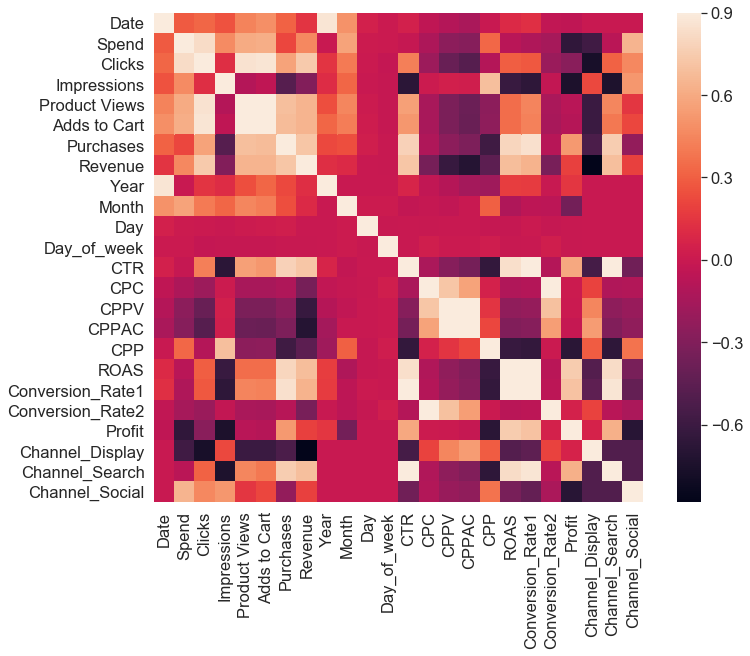

In [15]:
#Correlation map to see how features are correlated with SalePrice
corr = df_for_corr.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr, vmax=0.9, square=True)
plt.show()

# Skewness Measurement

* [Why we care and need to fix skewness](https://stats.stackexchange.com/questions/267078/why-is-skewed-data-not-preferred-for-modelling)
* Most test assume a gaussian distribution so do most models' error terms 
*

In [16]:
numeric = df.dtypes[df.dtypes != "object"].index
skewed_variables = df[numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_variables})
skewness.head(10)


Skew in numerical features: 



,Skew
CPC,15.268943
Conversion_Rate2,14.362148
CPPV,5.305384
CPPAC,3.838348
Purchases,1.813479
ROAS,1.778583
CPP,1.714447
Product Views,1.655350
Adds to Cart,1.631056
Conversion_Rate1,1.434579


# Split Train Test (Stratified Sampling)

In [17]:
y= df['Revenue']
X= df.drop(['Revenue'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=91, stratify = X.Channel)
X_test['Channel'].value_counts()

Search     146
Social     146
Display    146
Name: Channel, dtype: int64

In [18]:
X_train = pd.get_dummies(X_train)
print("X_train has {} entries and {} features".format(*X_train.shape))
X_test = pd.get_dummies(X_test)
print("X_test has {} entries and {} features".format(*X_test.shape))

X_train has 1752 entries and 23 features
X_test has 438 entries and 23 features


In [19]:
X_train.head()

,Date,Spend,Clicks,Impressions,Product Views,Adds to Cart,Purchases,Year,Month,Day,...,CPPV,CPPAC,CPP,ROAS,Conversion_Rate1,Conversion_Rate2,Profit,Channel_Display,Channel_Search,Channel_Social
524,736854,7700.0,2106,184471,208,92,12,2018,6,9,...,37.019231,83.695652,641.666667,1.658816,0.000065,0.005698,5072.882027,0,1,0
276,736606,10450.0,2536,337561,421,82,4,2017,10,4,...,24.821853,127.439024,2612.500000,0.288154,0.000012,0.001577,-7438.786873,0,1,0
363,736693,7700.0,1308,187962,267,82,12,2017,12,30,...,28.838951,93.902439,641.666667,1.009423,0.000064,0.009174,72.560013,0,1,0
1845,736715,1440.0,65,244728,8,3,1,2018,1,21,...,180.000000,480.000000,1440.000000,0.015781,0.000004,0.015385,-1417.275000,1,0,0
1199,736799,9570.0,1823,1089988,173,68,3,2018,4,15,...,55.317919,140.735294,3190.000000,0.140700,0.000003,0.001646,-8223.497029,0,0,1


# Predictions

## Root Mean Squared Error (RMSE) function to evaluate results 
* RMSE represents the sample standard deviation of the differences between predicted values and observed values (called residuals).
* Since the errors are squared before they are averaged, RMSE gives a relatively high weight to large errors (Penalizes it harder than MAE)

* This means the RMSE should be more useful when large errors are particularly undesirable.

* From an interpretation standpoint, MAE has the edge. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.
* However, an advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in terms of calculations and applications
* [What are good RMSE values](https://stats.stackexchange.com/questions/56302/what-are-good-rmse-values)
* [RMSE vs MAE 1](https://towardsdatascience.com/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0)
* [RMSE vs MAE 2](https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4)

$$ RMSE = \sqrt{\frac{1}{n}\sum^n_{j=1}(y_j-\hat{y}_j)^2 }$$
$$ MAE = \frac{1}{n}\sum{|y_i-\hat{y}_j|}$$

In [34]:
def rmse(predictions, targets): 
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_cv(model, x_train, y_train):
        rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=5))
        return rmse.mean()

# Multiple Linear regression 
* rmse is quite low already 0.32
* Do note that the R^2 is super high up to 0.979, this may also be a result of multicollinearity existing the in the data set as well as the fact that there are many predictor variables (Independent variables) 


In [35]:
rmse_cv(lr, X_train, y_train)

0.33146633901164224

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
lr = LinearRegression()
reg = lr.fit(X_train, y_train)

# R squared
print(reg.score(X_train, y_train))

predictions = reg.predict(X_train)
# adjusted R^2
print(r2_score(predictions, y_train.values))

print('Train rmse: ', rmse_cv(lr, X_train, y_train))

pred_linear = reg.predict(X_test)
print('Test rmse: ', rmse(pred_linear, y_test))

0.9794616012771902
0.9790309301599401
Train rmse:  0.33146633901164224
Test rmse:  0.3215518247347263


In [37]:
y_train.mean()

6.524381084368369

## VIF
### Usually we want to remove everything that is over a five

In [38]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(1).head()

,VIF Factor,features
0,184038.1,Date
1,125.3,Spend
2,28.1,Clicks
3,7.7,Impressions
4,44.1,Product Views


# Residuals, QQPLOT,  Scale Location
* Residuals vs Fitted. Used to check the linear relationship assumptions. A horizontal line, without distinct patterns is an indication for a linear relationship, what is good. Let's say that in our case the horizontal line is alright. There does seem to be some sort of patern at high fitted values, but will let it go and say there is some sort of linear relationship.

* Normal Q-Q. Used to examine whether the residuals are normally distributed. It’s good if residuals points follow the straight dashed line. In our case its fairly good we do see some sort of left skew.

* Scale-Location (or Spread-Location). Used to check the homogeneity of variance of the residuals (homoscedasticity). Horizontal line with equally spread points is a good indication of homoscedasticity. This is not the case in our example, where we have a heteroscedasticity problem.

## Many more things to consider outliers, Influence ploints, high leverage points, cooks distance. 

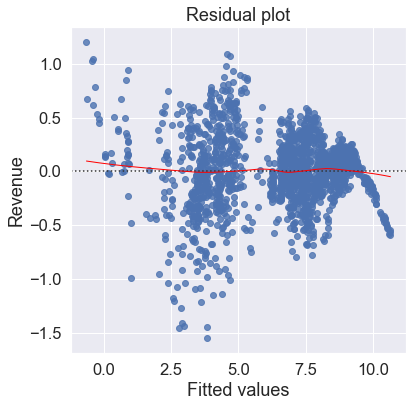

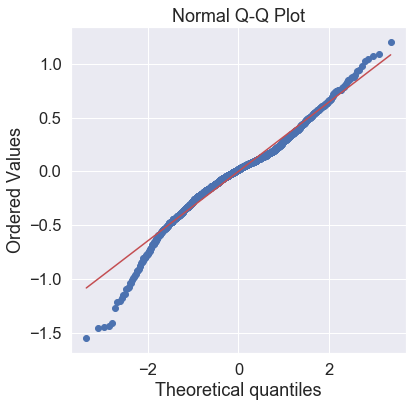

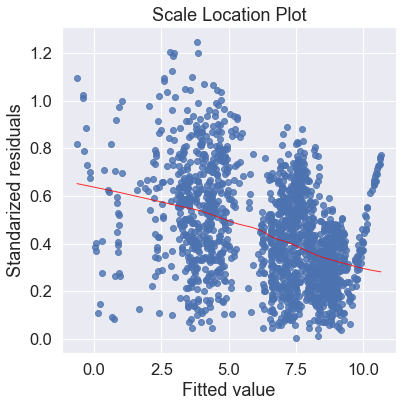

In [39]:
import scipy.stats as stats
plt.figure(figsize=(6,6))
sns.residplot(predictions, y_train,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

residuals = y_train - predictions
residuals

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(6,6))
sns.regplot(predictions.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")
plt.title("Scale Location Plot")
plt.show()

# XGBoost Regression

### In an ideal world, with infinite resources and where time is not an issue, you could run a giant grid search with all the parameters together and find the optimal solution.

In [45]:
from operator import itemgetter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score

#It will train until rmse hasn’t improved in 20 rounds. And the final output:

def default_test(train, test, random_state = 1995):
    # This can be altered as you wish 
    # we train
    eta = 0.1
    max_depth = 6
    subsample = 0.8
    colsample_bytree = 0.8
    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    
    params = {
        "objective": 'reg:squarederror',
        "booster" : "gbtree",
        "eval_metric": "rmse",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed":333
        }
    num_boost_round = 60
    early_stopping_rounds = 15
    test_size = 0.2

    dtrain = xgb.DMatrix(X_train, y_train)
    dvalidation= xgb.DMatrix(X_test, y_test) # test set
    watchlist = [(dtrain, 'train'), (dvalidation, 'eval')]

    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
    preds = gbm.predict(dvalidation)
    return(preds)
    
preds = default_test(X_train, y_train)

XGBoost params. ETA: 0.1, MAX_DEPTH: 6, SUBSAMPLE: 0.8, COLSAMPLE_BY_TREE: 0.8
[0]	train-rmse:5.80231	eval-rmse:5.7629
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 15 rounds.
[1]	train-rmse:5.22701	eval-rmse:5.1887
[2]	train-rmse:4.70896	eval-rmse:4.6729
[3]	train-rmse:4.24261	eval-rmse:4.20811
[4]	train-rmse:3.8224	eval-rmse:3.78974
[5]	train-rmse:3.4446	eval-rmse:3.41541
[6]	train-rmse:3.10443	eval-rmse:3.07675
[7]	train-rmse:2.79792	eval-rmse:2.77374
[8]	train-rmse:2.52138	eval-rmse:2.50006
[9]	train-rmse:2.27307	eval-rmse:2.25391
[10]	train-rmse:2.04855	eval-rmse:2.03114
[11]	train-rmse:1.84684	eval-rmse:1.831
[12]	train-rmse:1.66497	eval-rmse:1.65169
[13]	train-rmse:1.50141	eval-rmse:1.49006
[14]	train-rmse:1.3538	eval-rmse:1.34406
[15]	train-rmse:1.22075	eval-rmse:1.21307
[16]	train-rmse:1.10122	eval-rmse:1.09497
[17]	train-rmse:0.993638	eval-rmse:0.988253
[18]	train-rmse:0.896909	eval-rmse:0.8

# What is generally a good rmse value? This is really depends on the data you are working on if the continuous dependent variable is huge like then your rmse can be larger as well.

In [46]:
rmse(preds,y_test.values)

0.07219049096832111

# Ensemble stacking classifier from mlxtend
* So many regression methods to use but this is just overkill 

In [48]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

seed = 33

lasso = Lasso()
linear_reg = LinearRegression()
rf = RandomForestRegressor(n_estimators=5, random_state=seed)
xgb = XGBRegressor(objective= 'reg:squarederror')
ridge = Ridge(random_state=seed)


stack = StackingCVRegressor(regressors=(linear_reg,xgb, ridge,lasso, rf),
                            meta_regressor=xgb,
                            random_state=seed)

print('5-fold cross validation scores:\n')
for clf, label in zip([linear_reg,xgb, ridge,lasso, rf, stack], ['Linear Regression','XGBoost','Ridge','Lasso', 'Random Forest', 'StackingCVRegressor']):
    scores_R2 = cross_val_score(clf, X_train.as_matrix(), y_train, cv=5)
    scores_rmse = np.sqrt(-cross_val_score(clf, X_train.as_matrix(), y_train, cv=5, scoring='neg_mean_squared_error'))
    print("R^2 Score: %0.5f (+/- %0.5f) [%s]" % (scores_R2.mean(), scores_R2.std(), label))
    print("RMSE Score: %0.5f (+/- %0.5f) [%s] \n" % (scores_rmse.mean(), scores_rmse.std(), label))

5-fold cross validation scores:

R^2 Score: 0.97884 (+/- 0.00124) [Linear Regression]
RMSE Score: 0.33147 (+/- 0.01128) [Linear Regression] 

R^2 Score: 0.99803 (+/- 0.00022) [XGBoost]
RMSE Score: 0.10103 (+/- 0.00423) [XGBoost] 

R^2 Score: 0.97344 (+/- 0.00127) [Ridge]
RMSE Score: 0.37134 (+/- 0.00533) [Ridge] 

R^2 Score: 0.89475 (+/- 0.01109) [Lasso]
RMSE Score: 0.73838 (+/- 0.03923) [Lasso] 

R^2 Score: 0.99808 (+/- 0.00049) [Random Forest]
RMSE Score: 0.09904 (+/- 0.01089) [Random Forest] 

R^2 Score: 0.99843 (+/- 0.00015) [StackingCVRegressor]
RMSE Score: 0.09033 (+/- 0.00339) [StackingCVRegressor] 



In [49]:
stacked_regression = stack.fit(X_train.as_matrix(), y_train)
stacked_predictions = stacked_regression.predict(X_test.as_matrix())
rmse(stacked_predictions, y_test)

0.07968073191797624

### RMSE CV = 0.09985 and Test RMSE = 0.09447, matching and quite low indicating an alright model

# Now lets work with GridSearchCV to tune parameters and see if we can achieve an even lower RMSE

In [57]:
seed = 33

lasso = Lasso(random_state = seed)
linear_reg = LinearRegression()
rf = RandomForestRegressor(random_state=seed)
xgb = XGBRegressor(objective= 'reg:squarederror', max_depth = 6)
ridge = Ridge(random_state=seed)

stack = StackingCVRegressor(regressors=(linear_reg, xgb, ridge, lasso, rf),
                            meta_regressor=xgb,
                            random_state=seed)

grid = GridSearchCV(
    estimator=stack, 
    param_grid={
        'lasso__alpha': [x/5.0 for x in range(1, 5)],
        'ridge__alpha': [x/10.0 for x in range(1, 5)],
        'meta_regressor__n_estimators': [10, 100]}, 
    cv=5,
    refit=True, 
    scoring = 'neg_mean_squared_error'
)

grid.fit(X_train.as_matrix(), y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=StackingCVRegressor(cv=5,
                                           meta_regressor=XGBRegressor(base_score=0.5,
                                                                       booster='gbtree',
                                                                       colsample_bylevel=1,
                                                                       colsample_bynode=1,
                                                                       colsample_bytree=1,
                                                                       gamma=0,
                                                                       importance_type='gain',
                                                                       learning_rate=0.1,
                                                                       max_delta_step=0,
                                                                       max_depth=6,
           

In [70]:
print("Best RMSE: %f using %s" % (np.sqrt(-grid.best_score_), grid.best_params_))

predictions_grid  = grid.predict(X_test.as_matrix())

Best RMSE: 0.073890 using {'lasso__alpha': 0.8, 'meta_regressor__n_estimators': 100, 'ridge__alpha': 0.4}


In [67]:
rmse(predictions_grid, y_test)

0.0647907824638109

# Sources:
* [Understanding GLM](https://newonlinecourses.science.psu.edu/stat504/node/216/)
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)